In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
#import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
import dill as pickle
from copy import deepcopy
from collections import Counter

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from mcmodels.core.utils import get_ccf_data

from mcmodels.core import VoxelModelCache
from mcmodels.connectivity.creation import get_connectivity_matrices3
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures, get_leaves_ontologicalorder, get_indices_2ormore, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter
from mcmodels.models.expectedloss.crossvalidation import get_loss_surface_cv_spline
from mcmodels.models.expectedloss.crossvalidation import get_embedding_cv
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss, Crossval
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists,CrossvalNW

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = workingdirectory
INPUT_JSON = workingdirectory + '/data/meta/input_011520.json'
EXPERIMENTS_EXCLUDE_JSON = workingdirectory + '/data/meta/experiments_exclude.json'
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load(workingdirectory + '/data/meta/major_structures.npy')
major_structure_ids = np.load(workingdirectory + '/data/meta/major_structure_ids.npy')
data_info = pd.read_excel(workingdirectory + '/data/meta/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
with open('data/meta/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
ontological_order_leaves = np.load(workingdirectory + '/data/meta/ontological_order_leaves_v3.npy')
COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
folder =  '/Users/samsonkoelle/mouse_connectivity_models/data/raw/'

annotation/ccf_2017


In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False, structure_set_id=167587189, folder = folder)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()


512
703
1089
1097
315
313
354
698
771
803
477
549


In [4]:
ontological_order = get_ordered_summary_structures(cache,167587189)
#due to redundancy in ccfv3, remove 'MDRNv', 'MDRNd' from summary structures (include as leafs of MDRN)
ontological_order[277]
ontological_order = np.setdiff1d(ontological_order, [1098, 1107])


In [7]:
# targ_ord = ontological_order_leaves
# source_ord = ontological_order_leaves
# contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=1)
# #ontological_order = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_v3.npy')
# ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=2)


In [9]:
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/meta/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)

above_thresh = {}
thresh = 1
for m in range(12):
    sid = major_structure_ids[m]
    above_thresh[sid] = np.where(connectivity_data.structure_datas[sid].reg_inj.sum(axis = 1) > thresh)[0]

In [11]:
connectivity_data.structure_datas[sid].reg_inj.shape,above_thresh[sid].shape

((83, 44), (82,))

In [7]:
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].reg_proj_injnorm = connectivity_data.structure_datas[sid].reg_proj_injnorm[above_thresh[sid]]
    connectivity_data.structure_datas[sid].centroids = connectivity_data.structure_datas[sid].centroids[above_thresh[sid]]
    connectivity_data.creline[sid] = connectivity_data.creline[sid][above_thresh[sid]]
    connectivity_data.leafs[sid] = connectivity_data.leafs[sid][above_thresh[sid]]

gammas = np.asarray([0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
reg_proj_injnorm = {sid: connectivity_data.structure_datas[sid].reg_proj_injnorm for sid in major_structure_ids}
crelines = {sid: connectivity_data.creline[sid] for sid in major_structure_ids}
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.get_creleaf_combos()
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)
connectivity_data.get_creleaf_combos()
connectivity_data.cre2_index_matrices = get_indices_2ormore(crelines)
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)
creleaf2_evalindices = {sid: connectivity_data.creleaf2_evalindices[sid] for sid in major_structure_ids} 
cre2_index_matrices = {sid: connectivity_data.cre2_index_matrices[sid] for sid in major_structure_ids} 
connectivity_data.major2_index_matrices = {}
for sid in major_structure_ids:
     connectivity_data.major2_index_matrices[sid] =  np.expand_dims(np.ones(crelines[sid].shape),0)
major2_index_matrices = {sid:connectivity_data.major2_index_matrices[sid] for sid in major_structure_ids}

wtmajor2_index_matrices = {}
for sid in major_structure_ids:
    wtm = np.zeros(major2_index_matrices[sid].shape) 
    #print(wtm.shape)
    wtmajor2_index_matrices[sid] = wtm[:,np.where(crelines[sid] == 'C57BL/6J')[0]] = 1
#get_indices2(connectivity_data.creline[sid], np.asarray(['C57BL/6J']),leafs[sid])

#ncresum2_leaf2 = np.zeros(12)
#ncresum2 = np.zeros(12)
ncreleaf2 = np.zeros(12)
ntotal = np.zeros(12)
for i in range(12):
    sid = major_structure_ids[i]
    ntotal[i] = connectivity_data.structure_datas[sid].reg_proj.shape[0]
    #ncresum2_leaf2[i] =len(cresum2_leaf2_evalindices[sid])
    #ncresum2[i] = len(cresum2_evalindices[sid])
    ncreleaf2[i] = len(creleaf2_evalindices[sid])

major_structures = np.asarray(major_structures)
reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0], dtype = int)
df = pd.DataFrame([ntotal,  ncreleaf2], dtype = int, index=['Total','Cre-Leaf'], columns = major_structures[reo]).transpose()
#df = pd.DataFrame([ntotal, ncresum2, ncresum2_leaf2,  ncreleaf2], dtype = int, index=['Total','Cre-Summary','Cre-Summary, Leaf','Cre-Leaf']).transpose()
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Total &  Cre-Leaf \\
\midrule
Isocortex &     36 &         4 \\
OLF       &      7 &         2 \\
HPF       &    122 &        59 \\
CTXsp     &     85 &        38 \\
STR       &   1128 &       709 \\
PAL       &     68 &        18 \\
TH        &     46 &         7 \\
HY        &     35 &        17 \\
MB        &     33 &         8 \\
P         &     30 &        11 \\
MY        &     78 &        44 \\
CB        &     83 &        29 \\
\bottomrule
\end{tabular}



In [8]:
#get surfaces leaf
frac_learn = np.ones(12)
for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_leaf = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_injnorm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.leafs[sid],
                                                                                                 frac_learn[m])
    connectivity_data.structure_datas[sid].smoothed_losses_leaf = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_leaf,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_leaf.cre_distances_cv)
    

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/mouse_connectivity_models/mcmodels/models/expectedloss/shapeconstrained.py:47: RuntimeWarning: invalid value encountered in true_divide
  coordinates_normed = coordinates / np.linalg.norm(coordinates, axis=0)  # **2
/Users/s

In [14]:
leaf2_index_matrices = {sid: connectivity_data.leaf2_index_matrices[sid] for sid in major_structure_ids} 
distances = {sid: connectivity_data.structure_datas[sid].smoothed_losses_leaf for sid in major_structure_ids}
twostage_leaf_creleaf2 = CrossvalNW(reg_proj_injnorm, distances, leaf2_index_matrices, creleaf2_evalindices,gammas)
twostage_leaf_creleaf2.gammas = gammas #ds
twostage_leaf_creleaf2.predictions = twostage_leaf_creleaf2.get_predictions()
twostage_leaf_creleaf2.get_results_loocv()
twostage_leaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)
twostage_leaf_creleaf2.meanloss_weighted

array([0.49551171, 0.49739986, 0.32173125, 0.3991872 , 0.39679343,
       0.40309607, 0.43905424, 0.4370605 , 0.56212459, 0.43435694,
       0.32288283, 0.55636853])

In [15]:
creleaf2_index_matrices = {sid: connectivity_data.creleaf2_index_matrices[sid] for sid in major_structure_ids} 
leaf2_index_matrices = {sid: connectivity_data.leaf2_index_matrices[sid] for sid in major_structure_ids} 
pds = {}
for sid in major_structure_ids:
    pds[sid] = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
distances = pds

In [16]:


##{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}
nw_major_creleaf2 = CrossvalNW(reg_proj_injnorm, distances,major2_index_matrices, creleaf2_evalindices,gammas)
nw_major_creleaf2.gammas = gammas
nw_major_creleaf2.predictions = nw_major_creleaf2.get_predictions()
nw_major_creleaf2.get_results_loocv()
nw_major_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)
nw_major_creleaf2.meanloss_weighted


/Users/samsonkoelle/mouse_connectivity_models/mcmodels/models/voxel/crossvalidation.py:43: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


array([0.61503358, 0.49739986, 0.50141428, 0.45285174, 0.52831759,
       0.32440193, 0.5787992 , 0.54329415, 0.76407003, 0.45901867,
       0.43385579, 0.53944284])

In [17]:

nw_majorwt_creleaf2 = CrossvalNW(reg_proj_injnorm, distances,wtmajor2_index_matrices, creleaf2_evalindices,gammas)
nw_majorwt_creleaf2.gammas = gammas
nw_majorwt_creleaf2.predictions = nw_major_creleaf2.get_predictions()
nw_majorwt_creleaf2.get_results_loocv()
nw_majorwt_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)
nw_majorwt_creleaf2.meanloss_weighted

array([0.61503358, 0.49739986, 0.50141428, 0.45285174, 0.52831759,
       0.32440193, 0.5787992 , 0.54329415, 0.76407003, 0.45901867,
       0.43385579, 0.53944284])

In [18]:
nw_leaf_creleaf2 = CrossvalNW(reg_proj_injnorm, distances,leaf2_index_matrices, creleaf2_evalindices,gammas)
nw_leaf_creleaf2.gammas = gammas# ds
nw_leaf_creleaf2.predictions = nw_leaf_creleaf2.get_predictions()
nw_leaf_creleaf2.get_results_loocv()
nw_leaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)
nw_leaf_creleaf2.meanloss_weighted


array([0.50036524, 0.49739986, 0.44421051, 0.44156372, 0.53808516,
       0.35875086, 0.43972476, 0.44192978, 0.75809955, 0.43685968,
       0.36487684, 0.51449815])

In [11]:
distances = pds#{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}
nw_creleaf_creleaf2 = CrossvalNW(reg_proj_injnorm, distances,creleaf2_index_matrices, creleaf2_evalindices,gammas)
nw_creleaf_creleaf2.gammas = gammas# ds
nw_creleaf_creleaf2.predictions = nw_creleaf_creleaf2.get_predictions()
nw_creleaf_creleaf2.get_results_loocv()
nw_creleaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)
nw_creleaf_creleaf2.meanloss_weighted

/Users/samsonkoelle/mouse_connectivity_models/mcmodels/models/voxel/crossvalidation.py:43: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


array([0.84935969, 0.49739986, 0.33287695, 0.41457338, 0.40841117,
       0.39748724, 0.62144926, 0.49417978, 0.56213315, 0.51920372,
       0.35967607, 0.76923038])

In [12]:

#distances = pds#{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}
nw_cremajor_creleaf2 = CrossvalNW(reg_proj_injnorm, distances,cre2_index_matrices, creleaf2_evalindices,gammas)
nw_cremajor_creleaf2.gammas = gammas# ds
nw_cremajor_creleaf2.predictions = nw_cremajor_creleaf2.get_predictions()
nw_cremajor_creleaf2.get_results_loocv()
nw_cremajor_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)
nw_cremajor_creleaf2.meanloss_weighted


array([0.68923929, 0.49739986, 0.48341612, 0.43963934, 0.45388792,
       0.39641318, 0.55234092, 0.50476249, 0.56213231, 0.49746087,
       0.38668024, 0.76754001])

In [13]:
mean_gammas = np.ones(12)*0.000001
mean_creleaf_creleaf2 = CrossvalNW(reg_proj_injnorm, distances, creleaf2_index_matrices, creleaf2_evalindices,mean_gammas)
mean_creleaf_creleaf2.gammas = mean_gammas# ds
mean_creleaf_creleaf2.predictions = mean_creleaf_creleaf2.get_predictions()
mean_creleaf_creleaf2.get_results_loocv()
mean_creleaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)
nw_cremajor_creleaf2.meanloss_weighted

array([0.68923929, 0.49739986, 0.48341612, 0.43963934, 0.45388792,
       0.39641318, 0.55234092, 0.50476249, 0.56213231, 0.49746087,
       0.38668024, 0.76754001])

In [19]:
#el_labels = np.zeros(150, dtype = str)
models = np.asarray(['Mean','NW','NW','NW','NW','NW','EL'])
datas = np.asarray([r"$I_c \cap I_L$",
                   r"$I_c \cap I_M$",
                   r"$I_c \cap I_L$",
                    r"$I_L$",
                  r"$I_{wt} \cap I_M$",
                  r"$I_M$"  ,
                  r"$I_L$"])
multi_ind = np.vstack([models,datas])
multi_ind = np.asarray(multi_ind, dtype = str)
multi_ind = list(zip(*multi_ind))
multi_ind = pd.MultiIndex.from_tuples(multi_ind, names=[r"$\widehat f$",r"$\mathcal D$"])

reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0])
results = pd.DataFrame([mean_creleaf_creleaf2.meanloss_weighted,
nw_cremajor_creleaf2.meanloss_weighted,
nw_creleaf_creleaf2.meanloss_weighted,
nw_leaf_creleaf2.meanloss_weighted,
nw_majorwt_creleaf2.meanloss_weighted,
nw_major_creleaf2.meanloss_weighted,
twostage_leaf_creleaf2.meanloss_weighted], index = multi_ind, columns = major_structures).transpose()#, cre2_index_matrices
trunc = lambda x: math.trunc(1000 * x) / 1000;

results = results.applymap(trunc)

In [21]:
print(results.iloc[reo].to_latex(index=True,escape=False))


\begin{tabular}{lrrrrrrr}
\toprule
$\widehat f$ &           Mean & \multicolumn{5}{l}{NW} &     EL \\
$\mathcal D$ & $I_c \cap I_L$ & $I_c \cap I_M$ & $I_c \cap I_L$ &  $I_L$ & $I_{wt} \cap I_M$ &  $I_M$ &  $I_L$ \\
\midrule
Isocortex &          0.413 &          0.453 &          0.408 &  0.538 &             0.528 &  0.528 &  0.396 \\
OLF       &          0.499 &          0.504 &          0.494 &  0.441 &             0.543 &  0.543 &  0.437 \\
HPF       &          0.336 &          0.483 &          0.332 &  0.444 &             0.501 &  0.501 &  0.321 \\
CTXsp     &          0.497 &          0.497 &          0.497 &  0.497 &             0.497 &  0.497 &  0.497 \\
STR       &          0.359 &          0.386 &          0.359 &  0.364 &             0.433 &  0.433 &  0.322 \\
PAL       &          0.519 &          0.497 &          0.519 &  0.436 &             0.459 &  0.459 &  0.434 \\
TH        &          0.769 &          0.767 &          0.769 &  0.514 &             0.539 &  0.539 &  0.556 \

/Users/samsonkoelle/mouse_connectivity_models/mcmodels/core/plotting.py:17: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/Users/samsonkoelle/mouse_connectivity_models/mcmodels/core/plotting.py:31: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


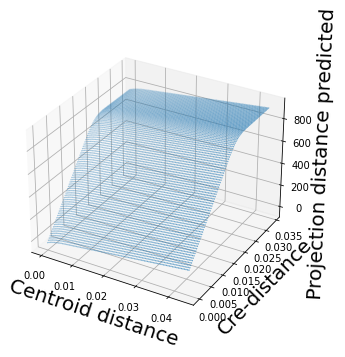

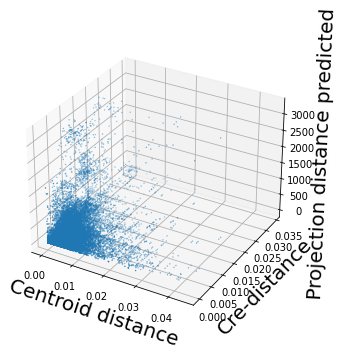

In [23]:
#there are some huge values for projection distance.... these are projections with a very small injection.
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_leaf)
plot_loss_scatter(connectivity_data.structure_datas[315].loss_surface_cv_leaf)